In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Import data

In [ ]:
metadata_path = os.path.join("D:", "OneDrive_1_5-26-2022", "pid2625_charlesjohnson.xlsx")
data_path = os.path.join("D:", "OneDrive_1_5-26-2022", "pid2625", "pid2625")
metadata = pd.read_excel(metadata_path)

In [ ]:
metadata.head(5)

In [ ]:
images = {}

for id in metadata["record"].unique():
    for eyeimage_i in metadata.loc[metadata['record'] == id]["field_name"]:
        if eyeimage_i in ["eyeimage1", "eyeimage2"]:
            file_name = metadata[(metadata["record"] == id) & (metadata["field_name"] == eyeimage_i)]["stored_name"].values[0]
            #print(id, eyeimage_i, file_name)
            image_path = os.path.join(data_path, file_name)
            img = cv2.imread(image_path)
            #cv2.imshow("preview", img)
            #cv2.waitKey(1000)
            #cv2.destroyAllWindows()
            
            #img = Image.open(image_path)
            #img.show()
            #imgArray = np.array(img)
            if not images.get(id):
                images[id] = {}
            #images[id][eyeimage_i] = imgArray
            images[id][eyeimage_i] = img

# Eye detection

In [ ]:
#print(images.keys())

In [ ]:
#print(images[2].keys())

## Preliminary screening

In [ ]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

if not os.path.exists("./raw eyes images"):
    os.makedirs("./raw eyes images")

for id, image_id in images.items():
    print(id)
    
    for i, image_i in image_id.items():
        print(i)

        #image_i = cv2.resize(image_i, (600, 800), interpolation = cv2.INTER_AREA)
        #eyes = eye_cascade.detectMultiScale(image_i, scaleFactor = 1.001, minNeighbors = 10, minSize=[150, 150], maxSize=[500, 500])
        eyes = eye_cascade.detectMultiScale(image_i, scaleFactor = 1.001, minNeighbors = 10, minSize=[600, 600], maxSize=[2000, 2000])
        
        # visualize the position of detected eyes
        #for (x,y,w,h) in eyes:
        #    cv2.rectangle(image_i,(x,y),(x+w,y+h),(0, 255, 0),5)
        #cv2.imshow("Eyes Detected", image_i)
        #cv2.waitKey(0)
        
        # crop images of detected eyes
        count = 0
        for (x,y,w,h) in eyes:
            count += 1
            eyes_image_i = image_i[y:y+h, x:x+w,:]
            #print(h, w)
            #cv2.imshow("Eyes Detected", eyes_image_i)
            #cv2.waitKey(0)
            if not os.path.exists("./raw eyes images/" + str(id)):
                os.makedirs("./raw eyes images/" + str(id))
            
            cv2.imwrite("./raw eyes images/" + str(id) + "/" + str(i) + "_" + str(count) + ".jpg", eyes_image_i)

## Labeling dataset (eyelid vs non-eyelid)

In [ ]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

if not os.path.exists("./count images"):
    os.makedirs("./count images")

count = 0
for id, image_id in images.items():
    print(id)
    
    for i, image_i in image_id.items():
        print(i)

        #image_i = cv2.resize(image_i, (600, 800), interpolation = cv2.INTER_AREA)
        #eyes = eye_cascade.detectMultiScale(image_i, scaleFactor = 1.001, minNeighbors = 10, minSize=[150, 150], maxSize=[500, 500])
        eyes = eye_cascade.detectMultiScale(image_i, scaleFactor = 1.001, minNeighbors = 10, minSize=[600, 600], maxSize=[2000, 2000])
        
        # visualize the position of detected eyes
        #for (x,y,w,h) in eyes:
        #    cv2.rectangle(image_i,(x,y),(x+w,y+h),(0, 255, 0),5)
        #cv2.imshow("Eyes Detected", image_i)
        #cv2.waitKey(0)
        
        # crop images of detected eyes
        for (x,y,w,h) in eyes:
            count += 1
            eyes_image_i = image_i[y:y+h, x:x+w,:]
            #print(h, w)
            #cv2.imshow("Eyes Detected", eyes_image_i)
            #cv2.waitKey(0)
            if not os.path.exists("./count images/" + str(id)):
                os.makedirs("./count images/" + str(id))
            
            cv2.imwrite("./count images/" + str(id) + "/" + str(id) + "_" + str(count) + ".jpg", eyes_image_i)

# Eyelid- and non-eyelid images classification

In [ ]:
eyelid_images_path = os.path.join("eyelid images")

seed_list = [123, 124, 125, 126, 127]
seed_num = 0

train_ds = image_dataset_from_directory(
  eyelid_images_path,
  validation_split=0.2,
  subset="training",
  seed=seed_list[seed_num],
  image_size=(224, 224),
  batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  eyelid_images_path,
  validation_split=0.2,
  subset="validation",
  seed=seed_list[seed_num],
  image_size=(224, 224),
  batch_size=32)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  model
])

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
p_tb = TensorBoard(log_dir='./logs/pretraining')
f_tb = TensorBoard(log_dir='./logs/finetuning')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[es, p_tb])

In [ ]:
for layer in base_model.layers[:249]:
   layer.trainable = False
for layer in base_model.layers[249:]:
   layer.trainable = True

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[es, f_tb])

In [ ]:
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

In [ ]:
for images, labels in val_ds.take(1):
  print(labels)
  y_hat = np.squeeze(model.predict(images) >= 0.5)
  print(y_hat)
  print("wrong: ", np.sum(labels != y_hat), "/", len(labels))

In [ ]:
model.save_weights("./models/" + str(seed_list[seed_num]) + "_" + str(0.9413) + "/")

# Eyelid Segmentation

## Finding potential eyelid images

In [ ]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

if not os.path.exists("./potential eyes images"):
    os.makedirs("./potential eyes images")

for id, image_id in images.items():
    print(id)
    
    for i, image_i in image_id.items():
        print(i)

        #image_i = cv2.resize(image_i, (600, 800), interpolation = cv2.INTER_AREA)
        #eyes = eye_cascade.detectMultiScale(image_i, scaleFactor = 1.001, minNeighbors = 10, minSize=[150, 150], maxSize=[500, 500])
        eyes = eye_cascade.detectMultiScale(image_i, scaleFactor = 1.0001, minNeighbors = 1, minSize=[600, 600], maxSize=[2000, 2000])
        
        # visualize the position of detected eyes
        #for (x,y,w,h) in eyes:
        #    cv2.rectangle(image_i,(x,y),(x+w,y+h),(0, 255, 0),5)
        #cv2.imshow("Eyes Detected", image_i)
        #cv2.waitKey(0)
        
        # crop images of detected eyes
        count = 0
        for (x,y,w,h) in eyes:
            count += 1
            eyes_image_i = image_i[y:y+h, x:x+w,:]
            #print(h, w)
            #cv2.imshow("Eyes Detected", eyes_image_i)
            #cv2.waitKey(0)
            if not os.path.exists("./potential eyes images/" + str(id)):
                os.makedirs("./potential eyes images/" + str(id))
            
            cv2.imwrite("./potential eyes images/" + str(id) + "/" + str(i) + "_" + str(count) + ".jpg", eyes_image_i)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  model
])

model.load_weights("./models/123_0.9413/")

In [ ]:
if not os.path.exists("./detected eyes images"):
    os.makedirs("./detected eyes images")
    
for folder in os.listdir("./potential eyes images"):
    for image in os.listdir(os.path.join("./potential eyes images", folder)):
        #print(image)
        img = cv2.imread(os.path.join("./potential eyes images", folder, image))
        #cv2.imshow("Eye detected", img)
        #cv2.waitKey(0)
        img = np.expand_dims(img, axis=0)
        y_hat = model.predict(img, verbose=0)
        #print(y_hat)
        
        if y_hat < 0.5:
            if not os.path.exists(os.path.join("./detected eyes images", folder)):
                os.makedirs(os.path.join("./detected eyes images", folder))
                
            cv2.imwrite(os.path.join("./detected eyes images", folder, image), img[0])

# Anemia prediction

## Load labels

In [2]:
label_path = os.path.join("D:", "OneDrive_1_5-26-2022", "PredictingAnemia_DATA_2022-06-05_0643.csv")
label = pd.read_csv(label_path)

In [3]:
label["hgb"] = pd.to_numeric(label["hgb"], errors="coerce")
drop_index = np.where(pd.isnull(label["hgb"]))
print("drop (contains string or null): ", drop_index[0])
label = label.drop(drop_index[0])
print("mean:", label["hgb"].mean(), "std:", label["hgb"].std())
print("anemia mean: ", label["hgb"][label["hgb"] < 12.5].mean())
print("non-anemia mean: ", label["hgb"][label["hgb"] >= 12.5].mean())

drop (contains string or null):  [122 328 485 502 585]
mean: 12.672859174964438 std: 3.7332914285381564
anemia mean:  10.47669696969697
non-anemia mean:  14.615844504021448


In [4]:
y = (label["hgb"] < 12.5).astype(int)
print(y.index)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            698, 699, 700, 701, 702, 703, 704, 705, 706, 707],
           dtype='int64', length=703)


In [5]:
y_available = [] 

for folder in os.listdir("./detected eyes images"):
    if int(folder)-1 in y.index:
        y_available.append(int(folder))
        
print("not available id: ")
not_available_id = []
for i in range(1, 693):
    if i not in y_available:
        not_available_id.append(i)
print(not_available_id)
print("num: ", len(not_available_id))

not available id: 
[17, 18, 26, 32, 35, 49, 68, 72, 88, 93, 111, 120, 123, 127, 173, 176, 198, 205, 206, 241, 243, 244, 250, 285, 293, 298, 316, 329, 341, 366, 368, 422, 442, 444, 445, 486, 503, 514, 532, 575, 586, 591, 613, 624, 646, 658, 675, 679, 688]
num:  49


## Load images

In [6]:
x_img = []
y_img = []
y_id = []

for id in y_available:
    for image in os.listdir(os.path.join("./detected eyes images", str(id))):
        #print(id, image)
        img = cv2.imread(os.path.join("./detected eyes images", str(id), image))
        #print(img.shape)
        x_img.append(tf.image.resize(img, (224, 224)))
        y_img.append(y[id-1])
        y_id.append(id)
        
x_img = np.array(x_img, dtype=np.uint8)
y_img = np.array(y_img)
print(x_img.shape, y_img.shape)

(1331, 224, 224, 3) (1331,)


## Data preprocessing

### HSV filter

In [7]:
dummy_sum = []

def hsv_filter(img, init_value=100, end_value=0, average_value=20000, adaptive=False):
    mask_value = 0
    sv_value = init_value
    
    if adaptive:
        while mask_value <= average_value and sv_value >= end_value:
            # Threshold of blue in HSV space
            lower_red = np.array([0,sv_value,sv_value])
            upper_red = np.array([10,255,255])
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            # preparing the mask to overlay
            mask = cv2.inRange(hsv, lower_red, upper_red)
            mask_value = np.sum(mask/255)
            sv_value -= 1
    else:
        lower_red = np.array([0,sv_value,sv_value])
        upper_red = np.array([10,255,255])
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # preparing the mask to overlay
        mask = cv2.inRange(hsv, lower_red, upper_red)
        mask_value = np.sum(mask/255)
        
    dummy_sum.append(mask_value)


    # The black region in the mask has the value of 0,
    # so when multiplied with original image removes all non-blue regions
    result = cv2.bitwise_and(img, img, mask = mask)
    
    return result

x_hsv = np.array([hsv_filter(xi, 100, 80, 20000, False) for xi in x_img], dtype=np.uint8)
print(x_hsv.shape)

print(np.mean(np.array(dummy_sum), axis=0))

(1331, 224, 224, 3)
12033.289256198346


In [8]:
# frame = x_img[60]
# result = x_hsv[60]

# cv2.imshow('frame', frame)
# cv2.imshow('result', result)

# cv2.waitKey(0)

# cv2.destroyAllWindows()

### Histrogram

In [9]:
# Blue, Green, Red and A (Transparency)
def red_histogram(img):
    return np.histogram(img[:, :, 2].flatten(), range(257))[0]

x_hist = np.array([red_histogram(xi) for xi in x_hsv])
print(x_hist.shape)

x_final = x_hist
y_final = y_img

(1331, 256)


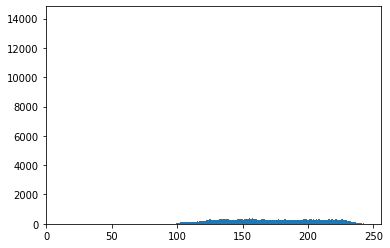

In [10]:
plt.bar(np.arange(256) - 0.5, x_hist[0], width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.show()

## Train test split

In [11]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# split_index = 0
# count = -1

# for train_index, test_index in skf.split(x_final, y_final):
#     count += 1
#     if split_index != count:
#         continue

#     x_train, y_train = x_final[train_index], y_final[train_index]
#     x_test, y_test = x_final[test_index], y_final[test_index]
    
# print(np.sum(y_train==0), np.sum(y_train==1))
# print(np.sum(y_test==0), np.sum(y_test==1))

In [12]:
# split by id
x_train, y_train = x_final[[i > 80 for i in y_id]], y_final[[i > 80 for i in y_id]]
x_test, y_test = x_final[[i <= 80 for i in y_id]], y_final[[i <= 80 for i in y_id]]

# x_train, y_train = x_final[[i < 620 for i in y_id]], y_final[[i < 620 for i in y_id]]
# x_test, y_test = x_final[[i >= 620 for i in y_id]], y_final[[i >= 620 for i in y_id]]

print(np.sum(y_train==0), np.sum(y_train==1))
print(np.sum(y_test==0), np.sum(y_test==1))

655 532
64 80


In [13]:
# plt.plot(np.arange(256) - 0.5, x_train[y_train==0].mean(axis=0), label='non-anemia')
# plt.plot(np.arange(256) - 0.5, x_train[y_train==1].mean(axis=0), label='anemia')
# plt.legend()
# plt.show()

In [14]:
# plt.plot(np.arange(256) - 0.5, x_test[y_test==0].mean(axis=0), label='non-anemia')
# plt.plot(np.arange(256) - 0.5, x_test[y_test==1].mean(axis=0), label='anemia')
# plt.legend()
# plt.show()

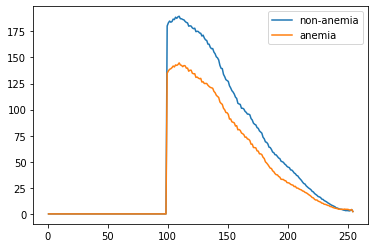

In [15]:
plt.plot(np.arange(256)[1:] - 0.5, x_train[y_train==0].mean(axis=0)[1:], label='non-anemia')
plt.plot(np.arange(256)[1:] - 0.5, x_train[y_train==1].mean(axis=0)[1:], label='anemia')
plt.legend()
plt.show()

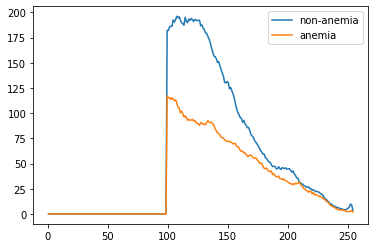

In [16]:
plt.plot(np.arange(256)[1:] - 0.5, x_test[y_test==0].mean(axis=0)[1:], label='non-anemia')
plt.plot(np.arange(256)[1:] - 0.5, x_test[y_test==1].mean(axis=0)[1:], label='anemia')
plt.legend()
plt.show()

## Classification

In [17]:
def print_results(y_true, y_hat):
    print("accuracy: ", accuracy_score(y_true, np.argmax(y_hat, axis=1)))
    print("precision: ", precision_score(y_true, np.argmax(y_hat, axis=1)))
    print("recall: ", recall_score(y_true, np.argmax(y_hat, axis=1)))
    print("roc auc: ", roc_auc_score(y_true, y_hat[:, 1]))
    print("f1: ", f1_score(y_true, np.argmax(y_hat, axis=1)))
    print("cohen kappa score: ", cohen_kappa_score(y_true, np.argmax(y_hat, axis=1)))
    y_hat = np.argmax(y_hat, axis=1)
    cm = confusion_matrix(y_true, y_hat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-anemia", "anemia"])
    disp.plot()
    plt.show()

accuracy:  0.5902777777777778
precision:  0.6615384615384615
recall:  0.5375
roc auc:  0.6062500000000001
f1:  0.593103448275862
cohen kappa score:  0.18931297709923656


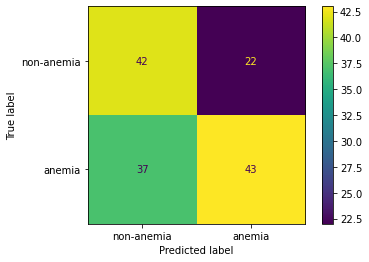

In [18]:
clf = LogisticRegression(random_state=0, max_iter=10000)
clf.fit(x_train, y_train)
print_results(y_test, clf.predict_proba(x_test))

accuracy:  0.5833333333333334
precision:  0.6785714285714286
recall:  0.475
roc auc:  0.602734375
f1:  0.5588235294117648
cohen kappa score:  0.1867469879518071


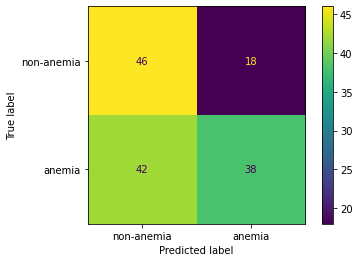

In [19]:
clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
clf.fit(x_train, y_train)
print_results(y_test, clf.predict_proba(x_test))

accuracy:  0.6805555555555556
precision:  0.9047619047619048
recall:  0.475
roc auc:  0.70341796875
f1:  0.6229508196721311
cohen kappa score:  0.38938053097345127


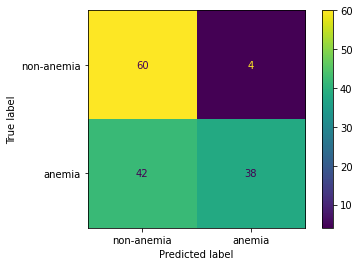

In [20]:
clf = SVC(random_state=0, probability=True)
clf.fit(x_train, y_train)
print_results(y_test, clf.predict_proba(x_test))

accuracy:  0.625
precision:  0.696969696969697
recall:  0.575
roc auc:  0.605078125
f1:  0.6301369863013698
cohen kappa score:  0.25688073394495414


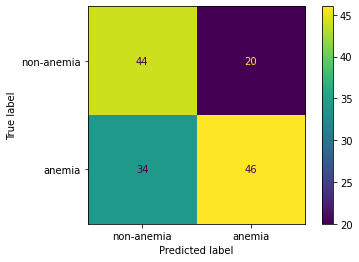

In [21]:
clf = XGBClassifier(random_state=0)
clf.fit(x_train, y_train)
print_results(y_test, clf.predict_proba(x_test))

## Visualization

In [84]:
# count = -1

# for train_index, test_index in skf.split(x_img, y_img):
#     count += 1
#     if split_index != count:
#         continue

#     x_img_train, y_img_train = x_img[train_index], y_img[train_index]
#     x_img_test, y_img_test = x_img[test_index], y_img[test_index]
    
# print(np.sum(y_img_train==0), np.sum(y_img_train==1))
# print(np.sum(y_img_test==0), np.sum(y_img_test==1))

x_img_train, y_img_train = x_img[[i > 80 for i in y_id]], y_img[[i > 80 for i in y_id]]
x_img_test, y_img_test = x_img[[i <= 80 for i in y_id]], y_img[[i <= 80 for i in y_id]]

predictions = np.argmax(clf.predict_proba(x_test), axis=1)
correct_index = predictions == y_test
for i, correct in enumerate(correct_index):
    if correct:
        correct_img = x_img_test[i]
        correct_img = correct_img.astype(np.uint8)
        cv2.putText(correct_img, str(y_test[i]), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.imshow("correct", correct_img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [ ]:
wrong_index = predictions != y_test
for i, wrong in enumerate(wrong_index):
    if wrong:
        wrong_img = x_img_test[i]
        wrong_img = wrong_img.astype(np.uint8)
        cv2.putText(wrong_img, str(y_test[i]), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.imshow("wrong", wrong_img)
        cv2.waitKey(500)
cv2.destroyAllWindows()